In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import time

from concurrent.futures import ThreadPoolExecutor
from preprocessing import load_image_from_path, image_to_numpy, random_augment_image, central_crop

%matplotlib inline

In [3]:
physical_device = tf.config.list_physical_devices('GPU')[0]
try:
  tf.config.experimental.set_memory_growth(physical_device, True)
except:
  tf.print("Invalid device or cannot modify virtual devices once initialized. Device name {}".format(
      physical_device.name
  ))
  pass

In [4]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [5]:
PATH_IMAGE = 'icons'

PATHS = get_files(PATH_IMAGE)

In [6]:
PATHS

['icons\\1 — Test.png',
 'icons\\10 — Cap.png',
 'icons\\2 — Medal.png',
 'icons\\3 — PC.png',
 'icons\\4 — Search.png',
 'icons\\5 — Projector.png',
 'icons\\6 — Idea.png',
 'icons\\7 — Telescope.png',
 'icons\\8 — Briefcase.png',
 'icons\\9 — Trofy.png']

In [13]:
def get_labeled_image(path, size):

    def _get_label(path):
        label = tf.strings.split(path, sep=' ')[0]
        label = tf.strings.split(label, sep=os.sep)[-1]
        label = tf.strings.to_number(label, out_type=tf.int32) - 1
        return label

    label = _get_label(path)
    image = load_image_from_path(path.numpy(), target_size=size)

    return (image, label)

In [122]:
def get_data(paths, counts=100, split=False):

    def get_augmented_image(path):
        image, label = get_labeled_image(path, (64, 64))
        image = random_augment_image(image)
        image = image_to_numpy(image) / 255.
        return [image, label]

    images = list()
    labels = list()
    data = list()

    paths = tf.random.shuffle(tf.repeat(paths, counts))
    size = len(paths)

    start_time = time.time()
    
    with ThreadPoolExecutor(8) as pool:
        data = list(pool.map(get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    tf.print("Loading data takes {:.3f}s".format(time.time()-start_time))

    if split:
        train_size = int(size*0.7)
        return (images[:train_size], labels[:train_size]), (images[train_size:], labels[train_size:])
    else:
        return images, labels

In [123]:
(train_images, train_labels), (test_images, test_labels) = get_data(PATHS, counts=500, split=True)

Loading data takes 109.330s


In [124]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(3500, 3500, 1500, 1500)

In [125]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(40)
train_dataset

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float64, tf.int32)>

In [126]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(40)

In [171]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((64, 64, 3)),
    tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(filters=12, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(filters=24, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(filters=12, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.SeparableConv2D(filters=12, kernel_size=3, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10),
], name='ArtWayClass')

model.summary()

Model: "ArtWayClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 6)         168       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 6)         24        
_________________________________________________________________
separable_conv2d_51 (Separab (None, 32, 32, 12)        138       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 12)        48        
_________________________________________________________________
separable_conv2d_52 (Separab (None, 16, 16, 24)        

In [172]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [173]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch+1) % 10 == 0:
            tf.print('Epoch {:4d} - loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f}, val_acc - {:.4f}'.format(
                epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

In [174]:
model.fit(
    train_dataset, 
    epochs=100,
    validation_data=test_dataset,
    callbacks=[CustomCallback()],
    verbose=0
)

Epoch    1 - loss: 2.6553 - acc: 0.2271, val_loss: 1.9896, val_acc - 0.2793
Epoch   10 - loss: 0.5020 - acc: 0.8117, val_loss: 0.7527, val_acc - 0.7307
Epoch   20 - loss: 0.2946 - acc: 0.8937, val_loss: 0.2737, val_acc - 0.9107
Epoch   30 - loss: 0.1737 - acc: 0.9323, val_loss: 0.0965, val_acc - 0.9713
Epoch   40 - loss: 0.1219 - acc: 0.9589, val_loss: 0.4126, val_acc - 0.8567
Epoch   50 - loss: 0.1063 - acc: 0.9620, val_loss: 0.0355, val_acc - 0.9900
Epoch   60 - loss: 0.0807 - acc: 0.9737, val_loss: 0.0901, val_acc - 0.9700
Epoch   70 - loss: 0.0764 - acc: 0.9731, val_loss: 0.1944, val_acc - 0.9373
Epoch   80 - loss: 0.0530 - acc: 0.9823, val_loss: 0.0838, val_acc - 0.9733
Epoch   90 - loss: 0.0665 - acc: 0.9786, val_loss: 0.0416, val_acc - 0.9860
Epoch  100 - loss: 0.0572 - acc: 0.9794, val_loss: 0.0375, val_acc - 0.9860


In [175]:
model.save('models/{}-0.5.h5'.format(model.name))

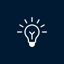

In [145]:
test_path = PATHS[6]

test_image = load_image_from_path(test_path, target_size=(64, 64))
test_image

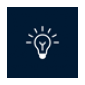

In [146]:
plt.figure(figsize=(1.3, 1.3))
plt.imshow(image_to_numpy(test_image)/255.)
plt.axis('off')
plt.show()